# Capstone 3: Making Predictions on Depletion of Five Natural Resources

## Production and Consumption: Synthetic Control

**Imports**

In [250]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.linear_model import Lasso
from numpy import mean
from numpy import std
from numpy import absolute

from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

In [75]:
!pip install pycausalimpact

### 1. Oil

In [372]:
# Load data
path1 = r'C:\Users\yuvem\ds_oil_consumption_melt.xlsx'
xls = pd.ExcelFile(path1)
ds = pd.read_excel(xls)
ds

,Country,Year,Barrels_daily
0,Canada,1965,1108.116301
1,Mexico,1965,315.871088
2,US,1965,11512.436000
3,NaN,1965,NaN
4,Argentina,1965,455.904822
...,...,...,...
5595,Taiwan,2020,973.107164
5596,Thailand,2020,1271.199472
5597,Vietnam,2020,490.671699
5598,Other Asia Pacific,2020,471.636775


In [373]:
ds.dropna()
ds.Country.unique()

array(['Canada', 'Mexico', 'US', nan, 'Argentina', 'Brazil', 'Chile',
       'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela',
       'Central America', 'Other Caribbean', 'Other South America',
       'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'Ukraine', 'United Kingdom', 'Other Europe ', 'Total Europe ',
       'Azerbaijan', 'Belarus', 'Kazakhstan', 'Russian Federation',
       'Turkmenistan', 'USSR', 'Uzbekistan', 'Other CIS', 'Iran', 'Iraq',
       'Israel', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia',
       'United Arab Emirates', 'Other Middle East', 'Algeria', 'Egypt',
       'Morocco', 'South Africa', 'Eastern 

In [374]:
ds.dtypes

Country           object
Year               int64
Barrels_daily    float64
dtype: object

In [375]:
ds.isna().sum()

Country          392
Year               0
Barrels_daily    729
dtype: int64

In [376]:
ds_clean = ds[ds["Country"].notna()] # clean nulls
ds_clean["Barrels_daily"] = ds_clean["Barrels_daily"].fillna(ds_clean.Barrels_daily.mean())

<ipython-input-376-3725465899bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_clean["Barrels_daily"] = ds_clean["Barrels_daily"].fillna(ds_clean.Barrels_daily.mean())


In [377]:
ds_clean.isna().sum()

Country          0
Year             0
Barrels_daily    0
dtype: int64

In [378]:
ds_clean['Year'] = pd.to_datetime(ds_clean.Year, format='%Y')

<ipython-input-378-70e3a9da4fbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_clean['Year'] = pd.to_datetime(ds_clean.Year, format='%Y')


In [379]:
ds_clean

,Country,Year,Barrels_daily
0,Canada,1965-01-01,1108.116301
1,Mexico,1965-01-01,315.871088
2,US,1965-01-01,11512.436000
4,Argentina,1965-01-01,455.904822
5,Brazil,1965-01-01,305.673808
...,...,...,...
5594,Sri Lanka,2020-01-01,103.544796
5595,Taiwan,2020-01-01,973.107164
5596,Thailand,2020-01-01,1271.199472
5597,Vietnam,2020-01-01,490.671699


In [380]:
i = ds_clean[((ds_clean.Country == 'Venezuela'))].index
i

Int64Index([  11,  111,  211,  311,  411,  511,  611,  711,  811,  911, 1011,
            1111, 1211, 1311, 1411, 1511, 1611, 1711, 1811, 1911, 2011, 2111,
            2211, 2311, 2411, 2511, 2611, 2711, 2811, 2911, 3011, 3111, 3211,
            3311, 3411, 3511, 3611, 3711, 3811, 3911, 4011, 4111, 4211, 4311,
            4411, 4511, 4611, 4711, 4811, 4911, 5011, 5111, 5211, 5311, 5411,
            5511],
           dtype='int64')

In [381]:
other_countries = ds_clean.drop(i)
other_countries

,Country,Year,Barrels_daily
0,Canada,1965-01-01,1108.116301
1,Mexico,1965-01-01,315.871088
2,US,1965-01-01,11512.436000
4,Argentina,1965-01-01,455.904822
5,Brazil,1965-01-01,305.673808
...,...,...,...
5594,Sri Lanka,2020-01-01,103.544796
5595,Taiwan,2020-01-01,973.107164
5596,Thailand,2020-01-01,1271.199472
5597,Vietnam,2020-01-01,490.671699


In [382]:
other_countries = other_countries[~other_countries.Year.duplicated(keep='first')]

In [383]:
other_countries = other_countries.drop(columns='Country', axis=1)

In [384]:
#

In [385]:
treatment = other_countries.rename({'Barrels_daily': 'Treatment'}, axis=1)
treatment.shape

(56, 2)

In [386]:
venezuela = ds_clean[((ds_clean.Country == 'Venezuela'))]
venezuela.shape

(56, 3)

In [387]:
venezuela = venezuela.drop(columns='Country', axis=1)

In [388]:
venezuela = venezuela[~venezuela.Year.duplicated(keep='first')]

In [389]:
control = venezuela.rename({'Barrels_daily': 'Control'}, axis=1)

In [390]:
#

In [391]:
indexed = treatment.set_index('Year')
indexed

,Treatment
Year,
1965-01-01,1108.116301
1966-01-01,1167.468795
1967-01-01,1245.557068
1968-01-01,1322.157350
1969-01-01,1380.190329
1970-01-01,1471.579753
1971-01-01,1512.128247
1972-01-01,1588.909235
1973-01-01,1754.885644


In [392]:
index_ven = control.set_index('Year')

In [393]:
df = indexed.append(index_ven)

In [394]:
#

In [395]:
df['Treatment'] = df.Treatment.fillna(df.Treatment.mean())
df['Control'] = df.Control.fillna(df.Control.mean())

In [396]:
df.index

DatetimeIndex(['1965-01-01', '1966-01-01', '1967-01-01', '1968-01-01',
               '1969-01-01', '1970-01-01', '1971-01-01', '1972-01-01',
               '1973-01-01', '1974-01-01',
               ...
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Year', length=112, freq=None)

In [416]:
x = df['Control'].unique()
y = df['Treatment'].unique()

In [417]:
y.shape

(57,)

In [418]:
x.shape

(57,)

In [419]:
x0_train, x0_test, y0_train, y0_test = train_test_split(x, y, test_size=0.25, random_state=2)
print(x0_train.shape, x0_test.shape, y0_train.shape, y0_test.shape)

(42,) (15,) (42,) (15,)


In [420]:
pre_period = ['1965-01-01','1985-01-01']
post_period = ['1986-01-01','2020-01-01']

In [421]:
#

In [422]:
ds_pivot = ds_clean.pivot_table(index='Year', columns='Country', values='Barrels_daily')
ds_pivot.shape

(56, 93)

In [423]:
null_columns = ds_pivot[ds_pivot.columns[ds_pivot.isna().any()]]
null_columns.columns

Index([], dtype='object', name='Country')

In [424]:
ds_pivot = ds_pivot.drop(columns='Azerbaijan')
ds_pivot = ds_pivot.drop(columns='Bangladesh')
ds_pivot = ds_pivot.drop(columns='Belarus')
ds_pivot = ds_pivot.drop(columns='Croatia')
ds_pivot = ds_pivot.drop(columns='Estonia')
ds_pivot = ds_pivot.drop(columns='Kazakhstan')
ds_pivot = ds_pivot.drop(columns='Latvia')
ds_pivot = ds_pivot.drop(columns='Lithuania')
ds_pivot = ds_pivot.drop(columns='North Macedonia')
ds_pivot = ds_pivot.drop(columns='Other CIS')
ds_pivot = ds_pivot.drop(columns='Russian Federation')
ds_pivot = ds_pivot.drop(columns='Slovenia')
ds_pivot = ds_pivot.drop(columns='Turkmenistan')
ds_pivot = ds_pivot.drop(columns='USSR')
ds_pivot = ds_pivot.drop(columns='Ukraine')
ds_pivot = ds_pivot.drop(columns='Uzbekistan')

In [425]:
ds_pivot.dropna(axis=1, how='all')

Country,Algeria,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Central America,Chile,...,Thailand,Total Europe,Trinidad & Tobago,Turkey,US,United Arab Emirates,United Kingdom,Venezuela,Vietnam,Western Africa
Year,,,,,,,,,,,,,,,,,,,,,
1965-01-01,26.716192,455.904822,343.871534,106.652849,312.112712,305.673808,71.220959,1108.116301,78.491296,70.516940,...,47.561397,8219.067934,35.171330,69.373863,11512.436000,1.525784,1466.077589,183.879953,31.347253,74.447750
1966-01-01,35.353233,471.145265,367.427507,118.205781,318.668110,334.602575,81.128658,1167.468795,79.329008,77.453144,...,55.992795,9037.460259,35.418008,82.812219,12084.373000,1.628466,1573.598685,181.469395,68.509536,80.229999
1967-01-01,33.285973,484.093001,401.463178,125.648575,350.395123,344.540164,101.827370,1245.557068,83.439596,81.568631,...,61.973425,9825.686232,36.954166,97.020521,12560.345000,1.752314,1696.268740,185.728871,100.338166,81.612307
1968-01-01,35.374426,493.491220,435.991175,144.321038,405.103388,412.432377,120.457158,1322.157350,84.877640,86.063510,...,81.130000,10775.430263,37.560230,116.565847,13392.866000,1.950681,1794.164536,201.425590,102.080276,81.389313
1969-01-01,37.714329,516.678254,450.960822,158.686932,468.287863,456.564904,148.471699,1380.190329,90.361137,92.454944,...,87.969644,12030.565864,39.486990,129.439507,14136.795000,2.173273,1930.183151,200.370616,123.713820,89.915851
1970-01-01,43.009918,473.100912,496.753507,175.707808,511.709370,512.724685,172.552877,1471.579753,93.457051,97.837721,...,102.808877,13323.154587,40.506249,136.220658,14697.186000,2.530832,2030.725507,209.874364,128.258016,98.774216
1971-01-01,48.878493,505.333808,523.101014,196.213233,525.207863,564.487699,189.468822,1512.128247,97.921517,108.043534,...,114.386575,13999.892651,41.858630,160.353781,15212.493000,2.985890,2036.777260,212.341753,108.502315,129.480936
1972-01-01,53.543497,501.607240,532.159372,211.859454,566.885410,648.893825,196.510656,1588.909235,106.334867,114.291311,...,142.747814,14952.103718,67.287186,181.113415,16366.984000,3.895519,2155.154317,230.821601,111.719328,138.277865
1973-01-01,58.849260,507.443178,569.900630,230.396247,597.895507,797.461233,207.978164,1754.885644,111.782780,109.558740,...,151.426247,16075.728601,68.266164,222.633973,17307.679000,6.062712,2228.135616,257.258740,109.934923,152.987508


In [426]:
ds_americas = ds_pivot[['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela']]
ds_americas.columns

Index(['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia',
       'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela'],
      dtype='object', name='Country')

In [427]:
# define model
lasso_model = Lasso(alpha=10)

In [428]:
x = ds_americas.drop(columns='Venezuela', axis=1)
x.columns

Index(['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia',
       'Ecuador', 'Peru', 'Trinidad & Tobago'],
      dtype='object', name='Country')

In [429]:
x.shape

(56, 10)

In [430]:
y = ds_americas[['Venezuela']]
y.shape

(56, 1)

In [431]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(42, 10) (14, 10) (42, 1) (14, 1)


In [432]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=5, max_iter=100, tol=0.1)
lasso_model = lasso_reg.fit(x_train, y_train)
lasso_model

Lasso(alpha=5, max_iter=100, tol=0.1)

In [433]:
lasso_reg.score(x_test, y_test)

0.8908557907088362

In [434]:
weights_lr = Lasso(fit_intercept=False, alpha=10).fit(x, y).coef_
weights_lr.round(3)

D:\User\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31060.772868755663, tolerance: 1337.767836978826
  model = cd_fast.enet_coordinate_descent(


array([ 0.162,  0.422, -0.027,  0.888,  0.179, -0.406, -1.85 , -0.385,
       -1.596,  0.957])

In [435]:
synth = x.values.dot(weights_lr)
synth.shape

(56,)

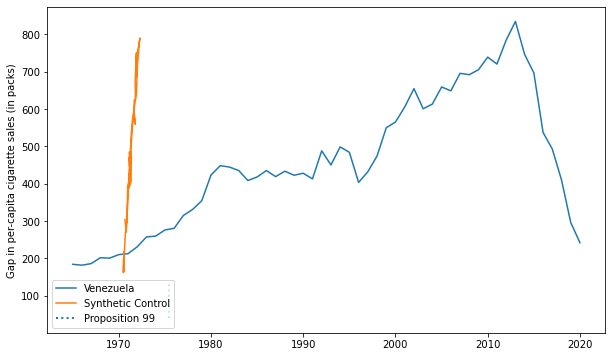

In [436]:
plt.figure(figsize=(10,6))
plt.plot(ds_americas.Venezuela, label="Venezuela")
plt.plot(ds_americas.Venezuela, synth, label="Synthetic Control")
plt.vlines(x=1980, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();